Carga y prepara el dataset

Define un preprocesador unificado

Entrena cuatro modelos (RandomForest, XGBoost, LightGBM con class_weight='balanced', y un StackingClassifier)

Evalúa cada uno en el mismo conjunto de test

Muestra los resultados en una tabla comparativa

In [6]:
# 0. Configuración y librerías
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

# 1. Carga de datos
df = pd.read_csv('../data/combined_sleep_dataset.csv')
df['Sleep_disorder'] = df['Sleep_disorder'].astype('category')

# 2. Separar X e y
X = df.drop(columns=['Sleep_disorder', 'Diagnosis_Confirmed'])
y = df['Sleep_disorder']

# 3. División entrenamiento/test estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 4. Preprocesador: escalado + one-hot
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

# 5. Definición de modelos base
models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        learning_rate=0.1,
        max_depth=7,
        n_estimators=100,
        random_state=42
    ),
    "LightGBM": LGBMClassifier(
        learning_rate=0.05,
        max_depth=5,
        n_estimators=200,
        subsample=0.8,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

# 6. Entrenar y evaluar cada modelo
results = {}
for name, clf in models.items():
    pipe = Pipeline([
        ('preproc', preprocessor),
        ('clf', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    results[name] = {
        "accuracy":     accuracy_score(y_test, y_pred),
        "precision_w":  precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "recall_w":     recall_score(y_test, y_pred, average='weighted'),
        "f1_w":         f1_score(y_test, y_pred, average='weighted'),
        "conf_matrix":  confusion_matrix(y_test, y_pred),
        "report":       classification_report(y_test, y_pred, zero_division=0)
    }

# 7. StackingClassifier con regresión logística como meta-modelo
estimators = [(n, Pipeline([('pre', preprocessor), ('clf', m)])) 
              for n, m in models.items()]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=StratifiedKFold(n_splits=3),
    n_jobs=-1,
    passthrough=True
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)

results["Stacking"] = {
    "accuracy":    accuracy_score(y_test, y_pred_stack),
    "precision_w": precision_score(y_test, y_pred_stack, average='weighted', zero_division=0),
    "recall_w":    recall_score(y_test, y_pred_stack, average='weighted'),
    "f1_w":        f1_score(y_test, y_pred_stack, average='weighted'),
    "conf_matrix": confusion_matrix(y_test, y_pred_stack),
    "report":      classification_report(y_test, y_pred_stack, zero_division=0)
}

# 8. Crear tabla comparativa de métricas
df_metrics = pd.DataFrame({
    name: {
        "Accuracy":       v["accuracy"],
        "Precision (w)":  v["precision_w"],
        "Recall (w)":     v["recall_w"],
        "F1-score (w)":   v["f1_w"]
    }
    for name, v in results.items()
}).T

print("\n=== Comparación de modelos ===")
print(df_metrics)

# 9. (Opcional) Mostrar matriz de confusión y reporte detallado del mejor
best = df_metrics["F1-score (w)"].idxmax()
print(f"\n>> El mejor según F1-weighted es: {best}\n")
print("Matriz de Confusión:")
print(results[best]["conf_matrix"])
print("\nReporte de Clasificación:")
print(results[best]["report"])


c:\Users\nsara\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:20:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 1804, number of used features: 11
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

c:\Users\nsara\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Comparación de modelos ===
              Accuracy  Precision (w)  Recall (w)  F1-score (w)
RandomForest  0.530973       0.655544    0.530973      0.562854
XGBoost       0.588496       0.538581    0.588496      0.560031
LightGBM      0.530973       0.658818    0.530973      0.562841
Stacking      0.539823       0.479051    0.539823      0.494582

>> El mejor según F1-weighted es: RandomForest

Matriz de Confusión:
[[70 22  9 26 20  5]
 [ 4 15 10  2  6  0]
 [ 0  9 10  4  0  0]
 [ 1 12 32 42 10  2]
 [ 2  5 11 11 12  2]
 [ 1  4  0  0  2 91]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.46      0.61       152
           1       0.22      0.41      0.29        37
           2       0.14      0.43      0.21        23
           3       0.49      0.42      0.46        99
           4       0.24      0.28      0.26        43
           5       0.91      0.93      0.92        98

    accuracy                           0.53 

c:\Users\nsara\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\nsara\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

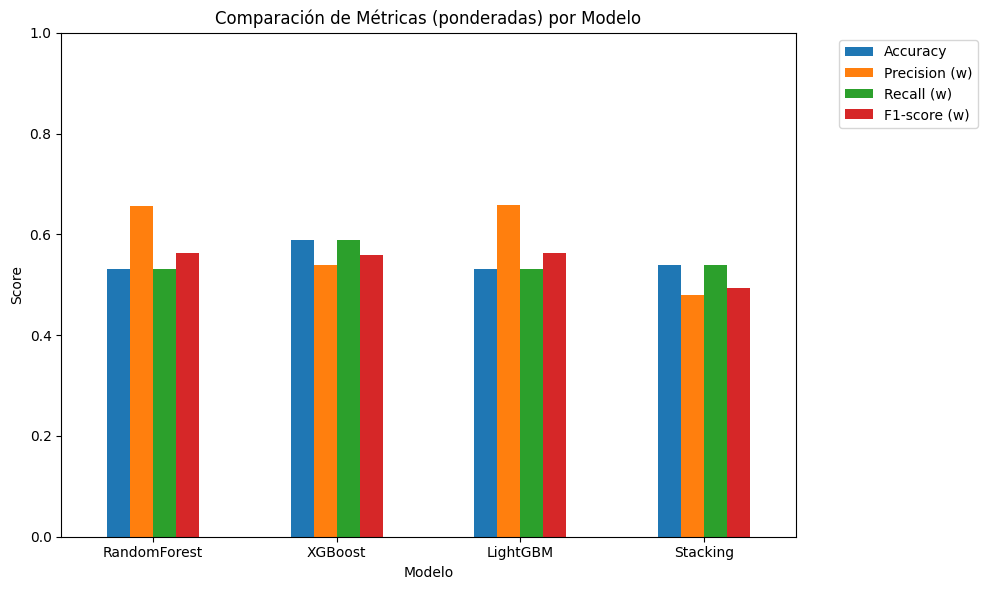

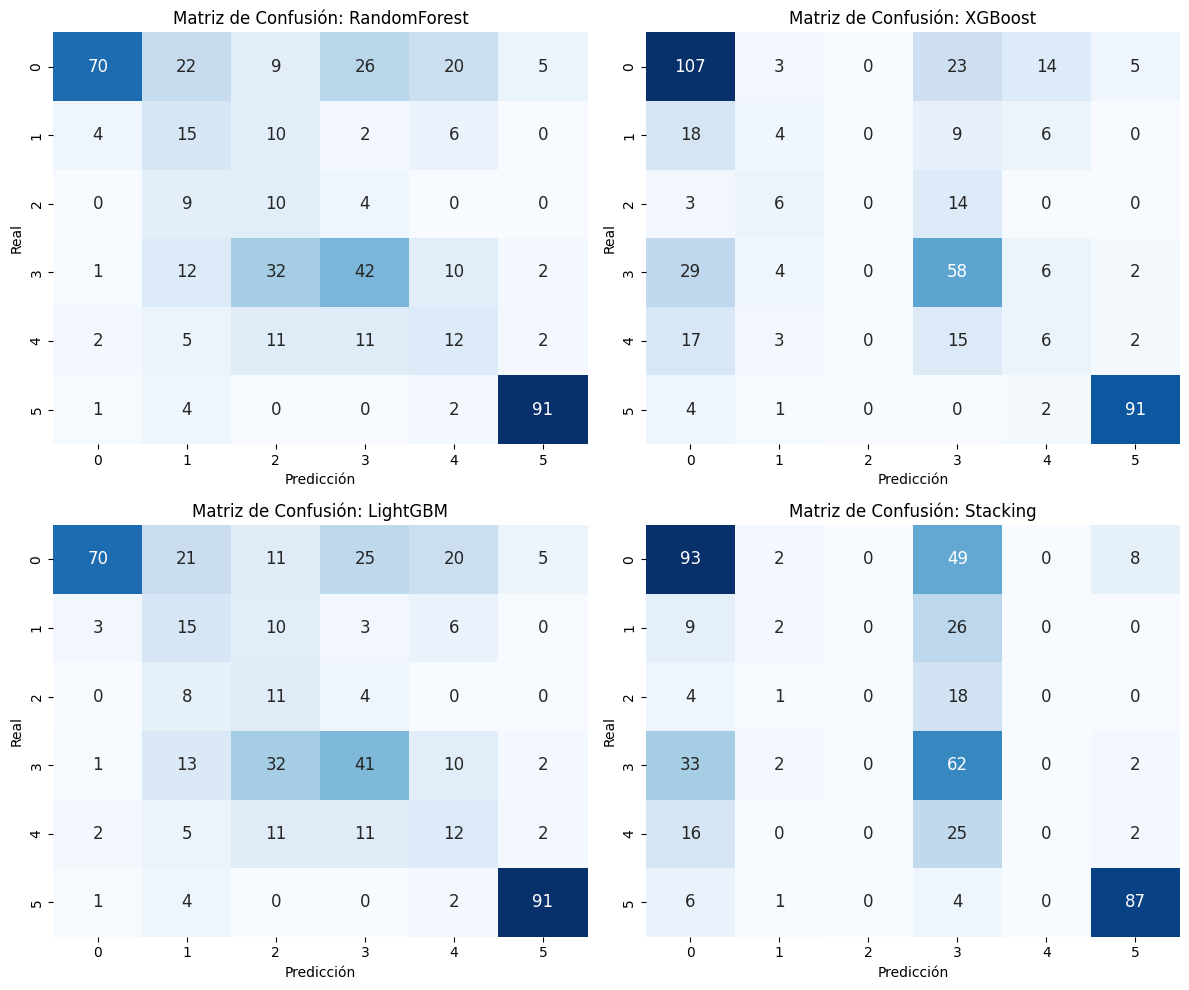

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Gráfica comparativa de métricas ponderadas
plt.figure(figsize=(10, 6))
df_metrics.plot(kind='bar', ylim=(0,1), rot=0, figsize=(10,6))
plt.title('Comparación de Métricas (ponderadas) por Modelo')
plt.ylabel('Score')
plt.xlabel('Modelo')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2) Heatmaps de las matrices de confusión de cada modelo
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, res) in zip(axes, results.items()):
    cm = res['conf_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar=False, annot_kws={"size":12})
    ax.set_title(f'Matriz de Confusión: {name}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

# Si tienes menos de 4 modelos, desactiva los ejes sobrantes
for ax in axes[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [13]:
import pickle
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

# 1) Recrea tu pipeline de entrenamiento con RF final
final_pipe = ImbPipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ))
])

# 2) Entrénalo sobre todo el dataset (o sólo X_train si prefieres)
final_pipe.fit(X_train, y_train)

# 3) Guarda el pipeline a disco con pickle
with open('clasificacion_tipo_trastorno.pkl', 'wb') as f:
    pickle.dump(final_pipe, f)
print("Modelo guardado en clasificacion_tipo_trastorno.pkl")

# 4) (Opcional) Evalúa una vez más sobre test
y_pred = final_pipe.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))




Modelo guardado en clasificacion_tipo_trastorno.pkl
              precision    recall  f1-score   support

           0       0.90      0.46      0.61       152
           1       0.22      0.41      0.29        37
           2       0.14      0.43      0.21        23
           3       0.49      0.42      0.46        99
           4       0.24      0.28      0.26        43
           5       0.91      0.93      0.92        98

    accuracy                           0.53       452
   macro avg       0.48      0.49      0.46       452
weighted avg       0.66      0.53      0.56       452



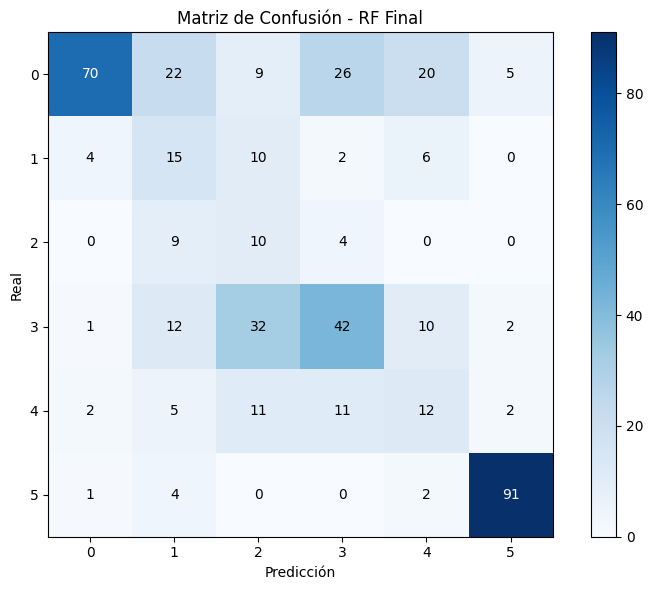

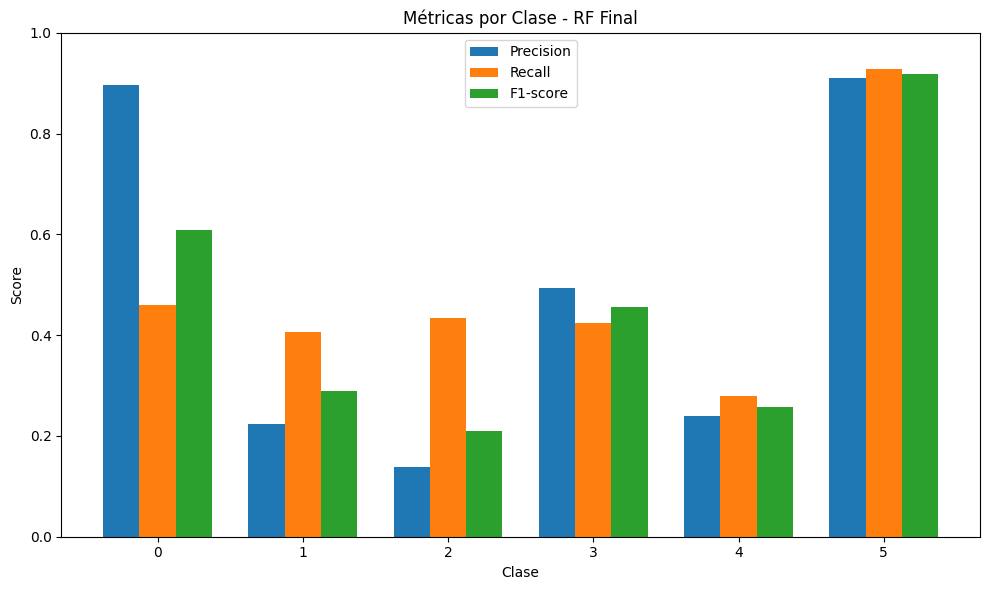

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 1) Carga y preparación de datos
df = pd.read_csv('../data/combined_sleep_dataset.csv')
df['Sleep_disorder'] = df['Sleep_disorder'].astype('category')
X = df.drop(columns=['Sleep_disorder', 'Diagnosis_Confirmed'])
y = df['Sleep_disorder']

# 2) División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 3) Preprocesador
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
])

# 4) Reconstrucción y entrenamiento del pipeline RF
pipe = Pipeline([
    ('preproc', preprocessor),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# 5) Matriz de Confusión como heatmap
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha='center', va='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black')
ax.set_title('Matriz de Confusión - RF Final')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# 6) Gráfico de barras de Precision / Recall / F1-score por clase
cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_cr = pd.DataFrame(cr).transpose()
clases = [c for c in df_cr.index if c not in ('accuracy', 'macro avg', 'weighted avg')]

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(clases))
width = 0.25
ax.bar([i-width for i in x], df_cr.loc[clases, 'precision'], width, label='Precision')
ax.bar(x,              df_cr.loc[clases, 'recall'],    width, label='Recall')
ax.bar([i+width for i in x], df_cr.loc[clases, 'f1-score'], width, label='F1-score')
ax.set_xticks(x)
ax.set_xticklabels(clases)
ax.set_ylim(0, 1)
ax.set_xlabel('Clase')
ax.set_ylabel('Score')
ax.set_title('Métricas por Clase - RF Final')
ax.legend()
plt.tight_layout()
plt.show()


In [8]:
#probar con keras

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# --- 1) Prepara X_train, X_test, y_train, y_test como antes ---
# (suponiendo que X y y ya están definidos)
X_train, X_test, y_train, y_test = train_test_split(
    X, y.cat.codes, test_size=0.2, random_state=42, stratify=y
)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Códigos → one-hot
num_classes = y.cat.categories.size
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

# Pesos de clase
class_weights = dict(zip(
    np.unique(y_train),
    compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
))

# --- 2) Define el modelo MLP ---
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# --- 3) Entrena ---
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[es],
    verbose=2
)

# --- 4) Evalúa en test ---
loss, acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
print(f"\nTest accuracy: {acc:.3f}")

y_pred_proba = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(
    y_test, y_pred,
    target_names=y.cat.categories.astype(str),
    zero_division=0
))


Epoch 1/50


c:\Users\nsara\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 - 2s - 34ms/step - accuracy: 0.2987 - loss: 1.6953 - val_accuracy: 0.3906 - val_loss: 1.4013
Epoch 2/50
46/46 - 0s - 4ms/step - accuracy: 0.4103 - loss: 1.5226 - val_accuracy: 0.4543 - val_loss: 1.3263
Epoch 3/50
46/46 - 0s - 4ms/step - accuracy: 0.4539 - loss: 1.4405 - val_accuracy: 0.4792 - val_loss: 1.2702
Epoch 4/50
46/46 - 0s - 4ms/step - accuracy: 0.4740 - loss: 1.4366 - val_accuracy: 0.4820 - val_loss: 1.2640
Epoch 5/50
46/46 - 0s - 4ms/step - accuracy: 0.4491 - loss: 1.4257 - val_accuracy: 0.4681 - val_loss: 1.2733
Epoch 6/50
46/46 - 0s - 5ms/step - accuracy: 0.4976 - loss: 1.3935 - val_accuracy: 0.4875 - val_loss: 1.2419
Epoch 7/50
46/46 - 0s - 4ms/step - accuracy: 0.4789 - loss: 1.4062 - val_accuracy: 0.4765 - val_loss: 1.2458
Epoch 8/50
46/46 - 0s - 4ms/step - accuracy: 0.4699 - loss: 1.3986 - val_accuracy: 0.4792 - val_loss: 1.2317
Epoch 9/50
46/46 - 0s - 4ms/step - accuracy: 0.4747 - loss: 1.3870 - val_accuracy: 0.4792 - val_loss: 1.2383
Epoch 10/50
46/46 - 0s - 4ms/

no ha mejorado nada, asi que no lo usaré